In [1]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from rnn_common.optimizer import SGD
from dataset import ptb
from rnnlm import RnnLanguageModel


In [2]:
# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

In [3]:
# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))



말뭉치 크기: 1000, 어휘 수: 418


In [4]:
# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

In [7]:
# 모델 생성
model = RnnLanguageModel(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]


In [8]:
for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0


| 에폭 1 | 퍼플렉서티 415.72
| 에폭 2 | 퍼플렉서티 328.10
| 에폭 3 | 퍼플렉서티 240.95
| 에폭 4 | 퍼플렉서티 222.37
| 에폭 5 | 퍼플렉서티 210.39
| 에폭 6 | 퍼플렉서티 205.96
| 에폭 7 | 퍼플렉서티 199.62
| 에폭 8 | 퍼플렉서티 197.49
| 에폭 9 | 퍼플렉서티 192.13
| 에폭 10 | 퍼플렉서티 192.47
| 에폭 11 | 퍼플렉서티 189.13
| 에폭 12 | 퍼플렉서티 191.91
| 에폭 13 | 퍼플렉서티 189.00
| 에폭 14 | 퍼플렉서티 189.93
| 에폭 15 | 퍼플렉서티 187.75
| 에폭 16 | 퍼플렉서티 184.56
| 에폭 17 | 퍼플렉서티 182.33
| 에폭 18 | 퍼플렉서티 178.88
| 에폭 19 | 퍼플렉서티 179.79
| 에폭 20 | 퍼플렉서티 180.16
| 에폭 21 | 퍼플렉서티 177.97
| 에폭 22 | 퍼플렉서티 174.41
| 에폭 23 | 퍼플렉서티 171.22
| 에폭 24 | 퍼플렉서티 171.58
| 에폭 25 | 퍼플렉서티 171.47
| 에폭 26 | 퍼플렉서티 169.04
| 에폭 27 | 퍼플렉서티 164.23
| 에폭 28 | 퍼플렉서티 161.46
| 에폭 29 | 퍼플렉서티 155.92
| 에폭 30 | 퍼플렉서티 151.54
| 에폭 31 | 퍼플렉서티 150.07
| 에폭 32 | 퍼플렉서티 142.84
| 에폭 33 | 퍼플렉서티 142.74
| 에폭 34 | 퍼플렉서티 136.79
| 에폭 35 | 퍼플렉서티 135.69
| 에폭 36 | 퍼플렉서티 127.76
| 에폭 37 | 퍼플렉서티 123.50
| 에폭 38 | 퍼플렉서티 120.48
| 에폭 39 | 퍼플렉서티 115.34
| 에폭 40 | 퍼플렉서티 110.16
| 에폭 41 | 퍼플렉서티 108.99
| 에폭 42 | 퍼플렉서티 101.68
| 에폭 43 | 퍼플렉서티 98.25
| 에폭 44 | 퍼플렉서티 93.91

### 평가지표 퍼플렉서티 설명
퍼플렉서티(perplexity, 혼란도)는 확률의 역수를 뜻한다.데이터가 한개일 때, 퍼플렉시티의 값은 분기의수(number of branches)를 의미하는데, 분기 수란 다음에 취할 수 있는 선택사항의 수(구체적으로 말하면, 다음에 출현할 수 있는 단어의 후보 수)를 말한다.  따라서 좋은 모델일수록 퍼블렉서티의 값은 작으며 최솟값은 1.0이다.
방금까지의 설명은 입력데이터가 하나일때의 설명이며 다음의 공식들은 입력 데이터가 여러개일 때의 공식이다.

$$L = \frac{-1}{N}\sum_{n}\sum_{k}t_{nk}\log y_{nk}$$
$$perplexity = e^{L}$$

$N$은 데이터의 총 개수 입니다. $t_{n}$은 원핫 벡터로 나타낸 정답 레이블이며, $t_{nk}$는 n개째 데이터의 k번째 값을 의미한다. 그리고
$y_{nk}$는 확률 분포를 나타낸다(신경망에서는 Softmax의 출력) L은 신경망의 손실을 뜻하며, 이 L을 사용해 $e^{L}$를 계산한 값이 곧 퍼플렉서티이다.식이 다소 복잡해보이지만, 데이터가 하나일 때, 설명한 '확률의 역수', '분기의 수', '선태사항의 수'같은 개념이 그대로 적용된다 즉 퍼플렉서티가 작아질 수록, 분기 수가 줄어 좋은 모델이 된다.

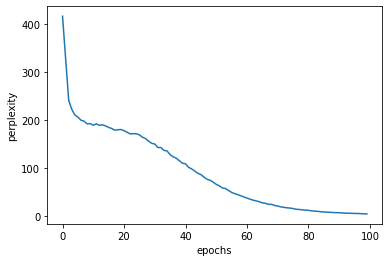

In [9]:
# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()
